# Discovering breast cancer subtypes in multi-omics data

Example code for Gurnari et al., "Probing omics data via harmonic persistent homology"

https://arxiv.org/abs/2311.06357

In [2]:
import numpy as np
import pandas as pd
import scipy

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import networkx as nx

import matilda
import matilda.prototyping
import matilda.harmonic
import seaborn as sns

import utils

## Load and process data

### Load clinical data

`data source goes here`

In [3]:
labels_df = pd.read_csv("data/brca_subtype.csv", index_col="patient")
labels_df.drop(labels_df.columns[0], axis=1, inplace=True)
labels_df

,Tumor.Type,Included_in_previous_marker_papers,vital_status,days_to_birth,days_to_death,days_to_last_followup,age_at_initial_pathologic_diagnosis,pathologic_stage,Tumor_Grade,BRCA_Pathology,...,tobacco_smoking_history,CNV Clusters,Mutation Clusters,DNA.Methylation Clusters,mRNA Clusters,miRNA Clusters,lncRNA Clusters,Protein Clusters,PARADIGM Clusters,Pan-Gyn Clusters
patient,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU,BRCA,NO,Alive,-20211.0,NaN,4047.0,55,NaN,NaN,NaN,...,NaN,C6,C7,C1,C1,C3,NaN,NaN,C5,NaN
TCGA-3C-AALI,BRCA,NO,Alive,-18538.0,NaN,4005.0,50,Stage_II,NaN,NaN,...,NaN,C6,C9,C2,C2,C3,NaN,C2,C4,C4
TCGA-3C-AALJ,BRCA,NO,Alive,-22848.0,NaN,1474.0,62,Stage_II,NaN,NaN,...,NaN,C6,C4,C2,C2,C2,NaN,NaN,C4,NaN
TCGA-3C-AALK,BRCA,NO,Alive,-19074.0,NaN,1448.0,52,Stage_I,NaN,NaN,...,NaN,C1,C5,C2,C2,C2,NaN,C2,C6,C4
TCGA-4H-AAAK,BRCA,NO,Alive,-18371.0,NaN,348.0,50,Stage_III,NaN,NaN,...,NaN,C6,C4,C1,C2,C2,NaN,C2,C6,C1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WT-AB44,BRCA,NO,Alive,NaN,NaN,883.0,77,Stage_I,NaN,NaN,...,NaN,C1,C7,C1,C2,C2,NaN,NaN,C8,NaN
TCGA-XX-A899,BRCA,NO,Alive,-17022.0,NaN,467.0,46,Stage_III,NaN,NaN,...,NaN,C6,C2,C1,C2,C2,NaN,C2,C6,C3
TCGA-XX-A89A,BRCA,NO,Alive,-25000.0,NaN,488.0,68,Stage_II,NaN,NaN,...,NaN,C3,C9,C1,C2,C2,NaN,NaN,C6,NaN


### Load RNA data
`data source goes here`

In [4]:
rna_df = pd.read_pickle("data/TCGA_RNASeq_TPM_HGNC_log2_nonas_transposed.pkl")
rna_df.index = [s.split("_")[1] for s in rna_df.index]
rna_df

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,LINC00602,MIR1291,LINC00891,PAUPAR,SPRY4-IT1,GIMAP1-GIMAP5,LINC01144,EMG1,PRICKLE4,TBC1D26
TCGA-OR-A5K3,13.965771,13.025328,13.385587,12.362007,12.219744,13.125251,11.822054,12.768203,12.374742,12.432223,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,12.251332,13.638891,12.239845,0.000000
TCGA-OR-A5JF,13.733599,12.193143,14.248436,13.564693,13.069548,11.862852,13.511544,13.048621,13.491564,12.965395,...,10.057422,14.620125,13.150497,0.0,16.183353,0.0,13.575339,13.545403,13.795078,12.762795
TCGA-OR-A5LK,14.092320,11.717036,12.506652,12.871540,12.391788,13.689739,11.888732,13.429717,13.037335,13.421576,...,0.000000,0.000000,14.674166,0.0,0.000000,0.0,12.264710,13.341493,13.930500,14.673653
TCGA-OR-A5K1,13.597561,11.290526,14.177351,13.153545,13.549944,13.019874,13.416971,13.191123,12.632355,13.196984,...,0.000000,14.132300,0.000000,0.0,0.000000,0.0,13.357270,13.923957,12.445820,0.000000
TCGA-PK-A5HA,13.032383,10.561539,12.898929,13.626629,13.306028,12.923738,13.969457,13.394062,13.505231,14.757954,...,0.000000,13.402987,13.518210,0.0,9.880190,0.0,11.956753,13.293752,11.939533,14.074274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-V4-A9EK,14.419713,0.000000,13.942134,14.076654,13.864812,15.676156,12.955530,13.176893,14.934411,14.906974,...,13.730985,0.000000,12.498014,0.0,12.308196,0.0,15.513172,13.304576,15.429669,0.000000
TCGA-V4-A9EM,13.859142,0.000000,13.017148,12.572301,13.647212,11.856585,11.401786,13.442666,13.167013,13.887710,...,15.081801,14.544193,0.000000,0.0,13.247461,0.0,13.271716,13.512026,15.448554,0.000000
TCGA-VD-AA8O,13.069174,0.000000,14.027434,13.744040,13.975653,13.976303,11.855084,14.444095,13.543830,12.909958,...,14.082959,0.000000,0.000000,0.0,10.724327,0.0,13.634634,13.014334,12.358595,0.000000
TCGA-V4-A9ES,11.959074,0.000000,13.983195,13.781284,14.319626,11.602752,10.204856,13.262649,13.359276,13.125259,...,13.329906,0.000000,0.000000,0.0,15.383384,0.0,13.261629,13.997186,12.749720,0.000000


### Load methylation450 data

downloaded from

https://xenabrowser.net/datapages/?dataset=TCGA-BRCA.methylation450.tsv&host=https%3A%2F%2Fgdc.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443

https://gdc-hub.s3.us-east-1.amazonaws.com/download/TCGA-BRCA.methylation450.tsv.gz

In [5]:
methy_df = pd.read_pickle("data/TCGA-BRCA.methylation450_nonas_transposed.pkl")
methy_df

Composite Element REF,cg00000029,cg00000165,cg00000236,cg00000289,cg00000292,cg00000363,cg00000622,cg00000658,cg00000721,cg00000734,...,rs7746156,rs798149,rs845016,rs877309,rs9292570,rs9363764,rs939290,rs951295,rs966367,rs9839873
TCGA-E9-A1NI,0.095978,0.338659,0.905511,0.789174,0.763993,0.523766,0.012291,0.904135,0.942963,0.063703,...,0.429022,0.976140,0.359002,0.971380,0.538542,0.486085,0.511583,0.028718,0.428460,0.959949
TCGA-A1-A0SP,0.180373,0.755176,0.849884,0.597847,0.714441,0.255256,0.010003,0.883748,0.931971,0.052195,...,0.021722,0.013119,0.491017,0.488211,0.616124,0.049026,0.328322,0.977102,0.443839,0.910627
TCGA-AR-A24O,0.183336,0.233811,0.908172,0.719929,0.647796,0.205028,0.011360,0.874225,0.954690,0.081647,...,0.474502,0.411851,0.476400,0.528674,0.492022,0.534342,0.024505,0.504480,0.469438,0.949719
TCGA-OL-A5RY,0.364438,0.265373,0.906329,0.729065,0.745001,0.347675,0.013981,0.825864,0.938649,0.066087,...,0.484030,0.401510,0.422727,0.513400,0.523420,0.533641,0.972008,0.509304,0.939145,0.065830
TCGA-BH-A0DG,0.238585,0.611880,0.887501,0.731672,0.570617,0.351793,0.009756,0.875855,0.943796,0.053335,...,0.019285,0.240139,0.462055,0.014733,0.975469,0.041947,0.973377,0.551063,0.947665,0.059931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-E2-A576,0.128993,0.761925,0.920783,0.706573,0.640102,0.236817,0.013662,0.910255,0.929295,0.047116,...,0.019184,0.328776,0.408696,0.015716,0.017918,0.054279,0.965387,0.027730,0.936624,0.854405
TCGA-B6-A0RN,0.150292,0.135920,0.928094,0.674650,0.799434,0.143661,0.009292,0.864260,0.951708,0.035963,...,0.476035,0.011465,0.473931,0.972115,0.017827,0.537089,0.566211,0.974849,0.929279,0.944446
TCGA-EW-A1P3,0.159162,0.420493,0.939415,0.792214,0.632080,0.417207,0.010792,0.880357,0.950296,0.064995,...,0.488012,0.271427,0.473955,0.576336,0.962821,0.041165,0.971816,0.971090,0.962513,0.609994
TCGA-B6-A409,0.112099,0.233254,0.912533,0.714594,0.548155,0.136024,0.013676,0.853398,0.947609,0.045026,...,0.022751,0.533070,0.030235,0.019118,0.966399,0.030472,0.973637,0.040922,0.957970,0.058352


### Select samples

In [10]:
index_list = labels_df[
    (labels_df["Tumor.Type"] == "BRCA")
    & (labels_df["BRCA_Subtype_PAM50"].isin(["Basal", "LumB", "LumA"]))
].index.tolist()

index_list = list(
    set(index_list).intersection(methy_df.index).intersection(rna_df.index)
)

index_list.sort()
len(index_list)

690

In [11]:
labels_df.loc[index_list]["BRCA_Subtype_PAM50"].value_counts()

BRCA_Subtype_PAM50
LumA     414
LumB     141
Basal    135
Name: count, dtype: int64

### PCA

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)

combined_df = pd.DataFrame(
    pca.fit_transform(
        pd.concat((rna_df.loc[index_list], methy_df.loc[index_list]), axis=1)
    ),
    index=index_list,
)

combined_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
TCGA-3C-AAAU,15.992909,-89.377739,52.233518,15.392217,-35.332649,-110.371765,-66.960148,50.194706,34.844557,8.802387,...,11.158185,-7.310925,24.518719,-14.471054,-5.580435,-0.243534,-35.037882,0.671599,-16.355612,-18.255468
TCGA-3C-AALJ,-78.366531,-31.433381,-19.837790,-5.578703,-52.368811,-132.304497,46.676625,28.860998,84.757326,2.669688,...,-7.403845,20.211441,-15.971987,27.744611,-11.100099,-28.759239,12.647260,-42.767027,-34.515297,-18.844571
TCGA-3C-AALK,14.414929,-29.595144,-71.181760,8.894295,-16.581761,-67.024789,-12.300903,-54.420715,41.748818,-24.361108,...,20.202781,-3.242433,-16.475653,-0.673799,4.070752,20.190008,-10.129709,19.834340,-17.775314,-4.232599
TCGA-4H-AAAK,-12.163051,-34.525732,-69.951131,-32.853234,8.550891,-54.370380,-1.405282,-68.536646,16.836889,-3.142640,...,-15.894342,-5.862839,5.721211,-21.915105,-16.005169,-21.625705,-6.718723,-10.179975,1.734791,-7.887890
TCGA-5L-AAT0,-51.610088,-15.071172,-133.017227,11.062309,1.814779,-72.172147,13.959149,-50.147436,-2.920053,-32.629972,...,-20.121991,-2.764013,-12.512566,-19.935922,3.060185,-5.761174,10.505288,-9.489912,2.649480,2.950756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WT-AB44,-172.980530,-12.908252,-48.954688,36.552339,105.556098,-84.234888,100.658272,-65.079874,-14.915333,8.328072,...,-7.204869,-2.507436,-10.057091,-22.208627,-1.529021,-9.877099,25.102002,-7.071280,-22.520233,-19.620845
TCGA-XX-A899,116.712155,6.373860,-116.472995,-5.205064,-17.196735,-80.875638,-3.583338,9.860203,29.463412,55.417058,...,-8.838633,-15.737800,8.683850,-8.267245,-0.298046,-16.551898,10.441830,5.716168,5.056944,2.919206
TCGA-XX-A89A,80.022750,26.655076,-106.021854,5.897371,-8.778921,-2.999757,12.785923,-2.623714,30.658877,57.746683,...,-14.946937,-6.476634,29.359787,5.889440,0.290601,-1.325640,-3.176677,31.745268,12.813971,-27.599961
TCGA-Z7-A8R5,-153.848083,77.686842,-144.835178,32.470579,87.770531,-61.617768,73.181773,-27.876634,-5.546430,-57.099176,...,-20.741637,-9.713867,-12.028390,4.930688,14.132351,-21.294312,3.993368,-2.622330,-15.803701,-9.515566


## Harmonics pipeline

### We use distance-correlation distance

In [13]:
from sklearn.metrics import pairwise_distances
import dcor

dm = 1 - pairwise_distances(
    X=combined_df.to_numpy(), metric=dcor.distance_correlation, n_jobs=-1
)
np.fill_diagonal(dm, 0)

print(dm.shape)

(690, 690)


### Visually inspect the histogram of distances
and distance to furthest closest neighbor, a good initial guess for an upper bound threshold for persistent homology computations

0.6985077892415541


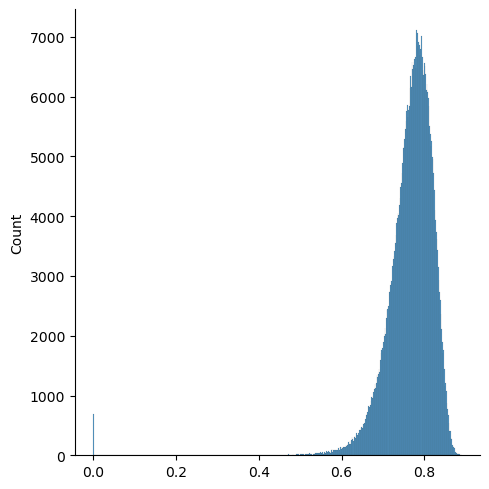

In [14]:
sns.displot(dm.ravel())

# This gives how far the distance of the element with the furthest closest neighbor to it
print(np.amax(np.amin(dm + np.diagflat([np.inf] * dm.shape[0]), axis=1)))

### Compute homology

In [14]:
%%time
H = 1
upper_bound = 0.75
max_dimension = 2

K_frompoints_co = matilda.FilteredSimplicialComplex()
K_frompoints_co.construct_vietoris_from_metric(dm, dimension=H+1, upper_bound=upper_bound)

# we need to use the prototype class
K = matilda.prototyping.FilteredSimplicialComplex(
    dimension=K_frompoints_co.dimension,
    simplices=K_frompoints_co.simplices,
    simplices_indices=K_frompoints_co.simplices_indices,
    appears_at=K_frompoints_co.appears_at,
)

for i in range(K.dimension + 1):
    print(
        "{} {}-dim simplices".format(
            len([s for s in K.simplices if len(s) == (i + 1)]), i
        )
    )

homology_computer = matilda.PersistentHomologyComputer()
homology_computer.compute_persistent_homology(K, with_representatives=True, modulus=0)

harmonic_computer = matilda.harmonic.HarmonicRepresentativesComputer(
                    K, homology_computer
                )

690 0-dim simplices
73115 1-dim simplices
3393933 2-dim simplices
0 3-dim simplices
CPU times: user 2min 15s, sys: 30.9 s, total: 2min 46s
Wall time: 3min 23s


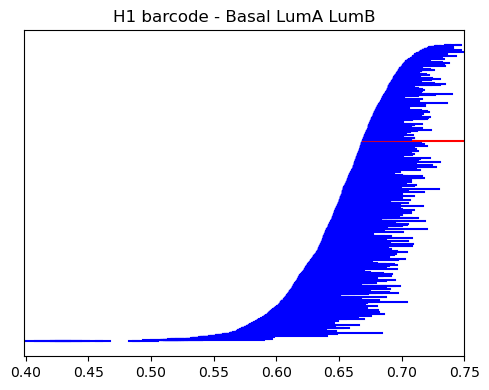

In [24]:
plotter = matilda.plot.Plotter()
plotter.plot_barcode(
    homology_computer,
    dimension=[H],
    figsize=(5, 4),
    max_x=upper_bound,
)
plt.title("H1 barcode - Basal LumA LumB")
plt.tight_layout()
plt.show()

### Sort bars according to their length and keep only the longest ones

In [17]:
len(homology_computer.bars[H])

2034

In [19]:
bar_len = sorted(
    [min(b[1], upper_bound) - b[0] for k, b in homology_computer.bars[H].items()],
    reverse=True,
)
bar_len[:10]

[0.12109357118606567,
 0.10059845447540283,
 0.09189063310623169,
 0.0911516547203064,
 0.08995705842971802,
 0.08686572313308716,
 0.0867300033569336,
 0.0866537094116211,
 0.08497905731201172,
 0.08458495140075684]

In [22]:
my_cycles = utils.cycles_longer_that(
    homology_computer=homology_computer, min_len=0.05, upper_bound=upper_bound
)

print(len(my_cycles))

202


### Compute harmonics
compute the harmonic representatives only for the bars we selected

In [23]:
harmonic_computer.compute_harmonic_cycles(
    dim=H, verbose=1, selected_cycles=[k for k in my_cycles], precompute=True
)

using the column reduced boundary matrix
202 cycles selected, we need to project 1624 1-dimensional cycles
precomputing boundary matrix
B shape (15752, 14675). Q shape (15752, 14675). 132.839s


  0%|          | 0/1624 [00:00<?, ?it/s]

In [25]:
# lets keep only the harmonic cycles corresponding to the bars we selected
my_harmonic_cycles = {
    k: c for k, c in harmonic_computer.harmonic_cycles[1].items() if k in my_cycles
}
len(my_harmonic_cycles)

202

### Save the harmonic weights in a DataFrame

In [26]:
nodes_dict, simplices_dict = utils.get_harmonic_weights(
    my_harmonic_cycles, K, index_list
)

In [45]:
weights_df = utils.get_harmonic_weights_df(
    nodes_dict, my_cycles, index_list, homology_computer, upper_bound
)
weights_df

,bar_id,birth,death,bar_length,TCGA-AR-A0TR,TCGA-LL-A5YN,TCGA-S3-AA10,TCGA-E2-A1LL,TCGA-A2-A4S3,TCGA-PE-A5DE,...,TCGA-E9-A1R2,TCGA-EW-A1J6,TCGA-AO-A125,TCGA-A7-A6VX,TCGA-BH-A0DP,TCGA-E2-A15J,TCGA-EW-A1P4,TCGA-EW-A1J3,TCGA-GM-A2DN,TCGA-E9-A1NC
0,771,0.407205,0.460976,0.053771,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1278,0.507770,0.590324,0.082555,0.000000,6.528629e-17,0.000000,2.012567e-17,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.245549,0.000000,0.000000,0.000000,0.000000,0.000000
2,1410,0.516445,0.594127,0.077682,0.000000,3.400138e-18,0.000000,5.580575e-17,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.309624,0.000000,0.000000,0.000000,0.000000,0.000000
3,1415,0.516891,0.575053,0.058162,0.000000,1.620888e-02,0.000000,1.844764e-17,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.117742,0.000000,0.000000,0.000000,0.000000,0.000000
4,1650,0.529370,0.596771,0.067402,0.000000,4.728675e-03,0.000000,1.773149e-17,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.005174,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,71321,0.667809,0.720296,0.052486,0.006013,6.105564e-03,0.003955,1.371081e-03,0.000000,0.005622,...,0.000420,0.001391,0.017026,0.001187,0.003522,0.017944,0.006040,0.010618,0.001586,0.006559
198,77379,0.669569,inf,0.080431,0.010617,9.117015e-03,0.008387,9.608338e-04,0.000000,0.018449,...,0.027859,0.005574,0.015725,0.003168,0.011402,0.020439,0.015020,0.019395,0.009772,0.017384
199,91162,0.673094,0.723461,0.050367,0.027960,4.689431e-02,0.011044,1.000580e-03,0.000000,0.011165,...,0.002205,0.001940,0.013323,0.006721,0.007854,0.030534,0.008653,0.009345,0.064701,0.011236
200,149590,0.683428,0.736199,0.052772,0.000636,2.587149e-02,0.001561,2.774549e-03,0.000000,0.003412,...,0.000716,0.010215,0.002722,0.001369,0.011152,0.005552,0.005763,0.004220,0.001402,0.006429


In [46]:
# save to file
weights_df.to_csv("output/weights_df.csv", index=False)

## ClusterMap
cluster together patients using weights from multiple cycles

In [60]:
weights_df = pd.read_csv("output/weights_df.csv")

In [61]:
weights_df = pd.read_csv("output/weights_df.csv")
weights_df

,birth,death,bar_length,TCGA-E2-A1BC,TCGA-D8-A1JH,TCGA-BH-A0B5,TCGA-A2-A0YF,TCGA-D8-A1XD,TCGA-E2-A105,TCGA-E2-A1II,...,TCGA-D8-A27F,TCGA-LL-A8F5,TCGA-AC-A62X,TCGA-S3-AA15,TCGA-E9-A2JS,TCGA-E9-A1N5,TCGA-A2-A0T6,TCGA-B6-A0X5,TCGA-AR-A1AP,TCGA-B6-A0X4
0,0.399177,0.467560,0.068383,0.000000,0.000000,7.720515e-17,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
1,0.473117,0.543193,0.070075,0.000000,0.000000,1.512715e-16,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.000000e+00
2,0.507177,0.594937,0.087760,0.000000,0.000000,7.377363e-03,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,3.740265e-17
3,0.517988,0.574179,0.056192,0.000000,0.000000,2.348304e-03,0.000000,0.000000e+00,0.000000,0.000000,...,6.016758e-19,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,6.490187e-17
4,0.526096,0.577480,0.051385,0.000000,0.000000,2.603964e-17,0.000000,9.028012e-35,0.000000,0.000000,...,4.583198e-33,0.000000,0.000000,0.000000,0.000000,1.326548e-33,0.000000,0.000000,0.000000,2.267972e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.664899,0.720947,0.056048,0.008690,0.022394,2.622037e-02,0.032032,6.417510e-03,0.000515,0.008629,...,2.776874e-02,0.000875,0.051251,0.016729,0.021616,8.016351e-01,0.307387,0.000085,0.002739,2.005778e-02
196,0.666382,0.716674,0.050292,0.009949,0.068582,2.113812e-02,0.007949,7.612032e-03,0.000454,0.003038,...,1.603665e-02,0.003156,0.019659,0.017203,0.024476,6.916969e-01,0.232608,0.000050,0.000904,1.573026e-02
197,0.669686,0.728691,0.059005,0.012894,0.012807,2.112463e-02,0.006168,6.082538e-03,0.000291,0.014201,...,7.618114e-03,0.002103,0.003559,0.009295,0.019071,5.798530e-03,0.024491,0.000169,0.005157,5.283639e-03
198,0.675671,0.732155,0.056485,0.011886,0.029866,1.045026e-02,2.000000,6.456670e-03,0.001064,0.004487,...,9.593747e-03,0.005392,0.012793,0.015892,0.016353,1.723502e-01,0.112121,0.000499,0.004182,3.352295e-02


In [62]:
# the columns to display on top of the heatmap
my_cols = [
    "BRCA_Subtype_PAM50",
    "CNV Clusters",
    "DNA.Methylation Clusters",
    "mRNA Clusters",
    "miRNA Clusters",
    "lncRNA Clusters",
    "Protein Clusters",
    "PARADIGM Clusters",
    "Pan-Gyn Clusters",
]

In [63]:
## select only long bars
to_heat = weights_df.loc[weights_df.bar_length > 0.07, weights_df.columns[4:]]
## select only those samples that have an high weight (>0.1) on at least one harmonic cycle
to_heat = to_heat.loc[:, (to_heat > 0.1).any(axis=0)]
to_heat

,TCGA-D8-A1JH,TCGA-BH-A0B5,TCGA-D8-A1XD,TCGA-E2-A1II,TCGA-A7-A3IZ,TCGA-JL-A3YX,TCGA-AR-A24M,TCGA-BH-A1FG,TCGA-BH-A204,TCGA-AC-A5XS,...,TCGA-AC-A6IW,TCGA-A1-A0SI,TCGA-GM-A2DI,TCGA-AO-A0JI,TCGA-D8-A27F,TCGA-AC-A62X,TCGA-E9-A2JS,TCGA-E9-A1N5,TCGA-A2-A0T6,TCGA-B6-A0X4
1,0.000000,1.512715e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,2.000000e+00
2,0.000000,7.377363e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,3.740265e-17
8,0.000000,1.932419e-03,1.053778e-17,4.358550e-19,0.000000e+00,0.000000,0.000000,0.000000,1.121592e-17,0.000000,...,1.113079e-17,0.000000,0.000000,0.000000,4.940675e-17,0.000000,0.000000,9.299059e-18,2.115445e-17,8.837936e-02
11,0.000000,7.910197e-03,1.413676e-17,9.405500e-18,2.410297e-18,0.000000,0.000000,0.030690,5.678467e-19,0.000000,...,2.991924e-17,0.000000,0.000000,0.000000,4.106134e-17,0.000000,0.000000,1.013313e-17,2.391127e-17,2.318689e-02
12,0.000000,6.788236e-04,1.425670e-18,3.525491e-18,6.332647e-18,0.000000,0.000000,0.000042,5.601845e-18,0.000000,...,9.368433e-18,0.000000,0.000000,0.000000,9.180919e-17,0.000000,0.000000,4.236257e-17,4.108728e-17,2.243526e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.021844,1.296134e-02,2.198683e-02,1.280559e-03,2.729294e-03,0.011081,0.038807,0.317994,2.773274e-02,0.003665,...,8.728359e-03,0.004903,0.056584,0.027232,2.673737e-02,0.003674,0.009284,9.668256e-03,5.439469e-02,6.189796e-03
173,0.005819,1.464930e-02,2.014679e-02,1.229218e-03,2.000000e+00,0.014936,0.007643,0.103152,4.188074e-01,0.001043,...,4.735309e-03,0.000294,0.005786,0.011398,1.520302e-02,0.001716,0.103223,1.501103e-03,1.599886e-02,9.099843e-03
179,0.075710,5.229851e-03,2.805716e-03,1.511869e-03,1.282518e-03,0.003005,0.248606,0.017314,1.408853e-01,0.317406,...,1.293171e-02,0.000908,0.004470,0.014787,5.946595e-02,0.005432,0.010647,1.161842e-03,2.498160e-02,4.614469e-02
184,0.022571,9.535937e-03,5.017351e-03,2.872314e-03,2.145020e-02,0.003610,0.024107,0.042703,2.915604e-01,0.005314,...,9.458548e-03,0.001268,0.019538,0.206371,1.072958e-02,0.005821,0.042396,2.084631e-03,3.621316e-02,9.703693e-03


/Users/dgurnari/opt/anaconda3/envs/tda/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/dgurnari/opt/anaconda3/envs/tda/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


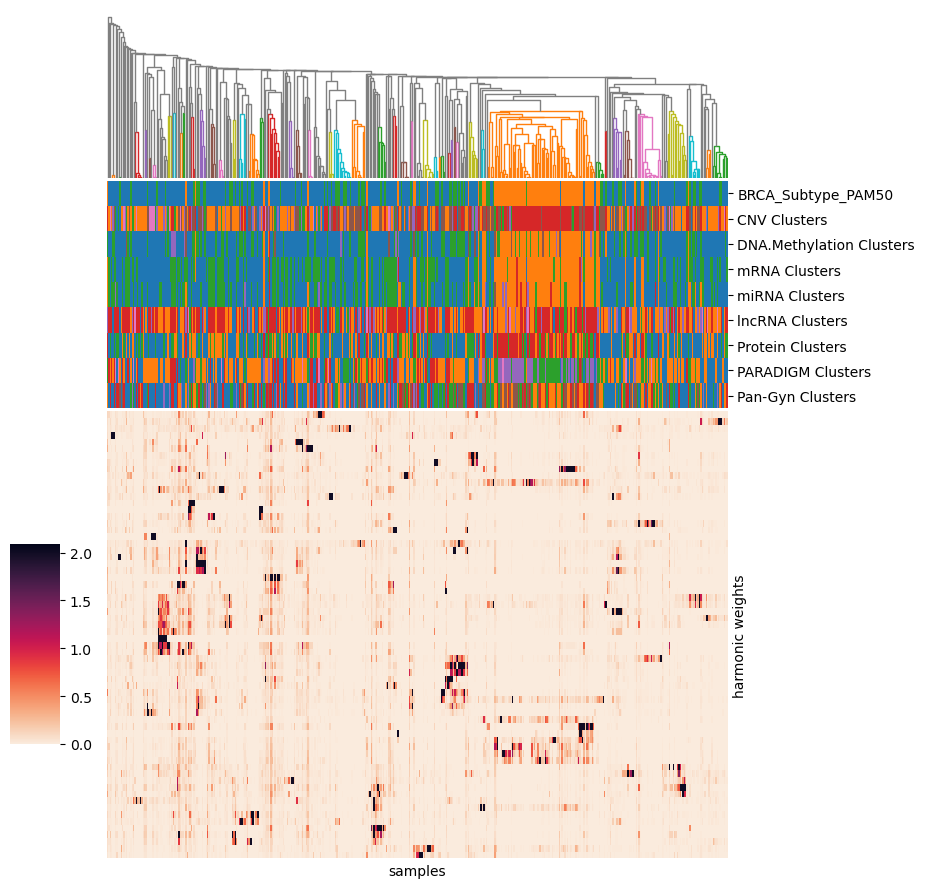

In [64]:
rows_df = pd.DataFrame(labels_df.loc[to_heat.columns][my_cols])

row_colors = rows_df.copy()
for col in rows_df.columns:
    row_colors[col] = rows_df[col].map(
        dict(
            zip(
                rows_df[col].unique(),
                sns.color_palette(palette="tab10", n_colors=len(rows_df[col].unique())),
            )
        )
    )

cm = sns.clustermap(
    to_heat,
    metric="correlation",
    method="single",
    cmap="rocket_r",
    row_cluster=True,
    col_colors=row_colors,
    cbar_pos=(0.08, 0.25, 0.05, 0.2),
)


with plt.rc_context({"lines.linewidth": 1}):
    cm.dendrogram_col.dendrogram = scipy.cluster.hierarchy.dendrogram(
        cm.dendrogram_col.linkage,
        color_threshold=0.2,
        above_threshold_color="grey",
        ax=cm.ax_col_dendrogram,
    )
cm.ax_row_dendrogram.set_visible(False)

cm.ax_heatmap.xaxis.set_label_text("samples")
cm.ax_heatmap.xaxis.set_ticks([])
cm.ax_heatmap.yaxis.set_label_text("harmonic weights")
cm.ax_heatmap.yaxis.set_ticks([])

# plt.savefig('clustermap_multi.pdf')

plt.show()

## Inspect the samples in the orange cluster

In [65]:
clusters_id = scipy.cluster.hierarchy.fcluster(
    cm.dendrogram_col.linkage, t=0.2, criterion="distance"
)

## now let's group points in the same cluster into a dict

ensemble_cc = {}

for i, k in enumerate(clusters_id):
    ensemble_cc.setdefault(k, set()).add(i)

for k in ensemble_cc:
    if len(ensemble_cc[k]) > 10:
        print(k, len(ensemble_cc[k]))

113 14
98 78
109 18
58 13
124 11


In [66]:
labels_df.loc[[to_heat.columns[i] for i in ensemble_cc[98]]][
    "BRCA_Subtype_PAM50"
].value_counts()

BRCA_Subtype_PAM50
Basal    70
LumA      4
LumB      4
Name: count, dtype: int64

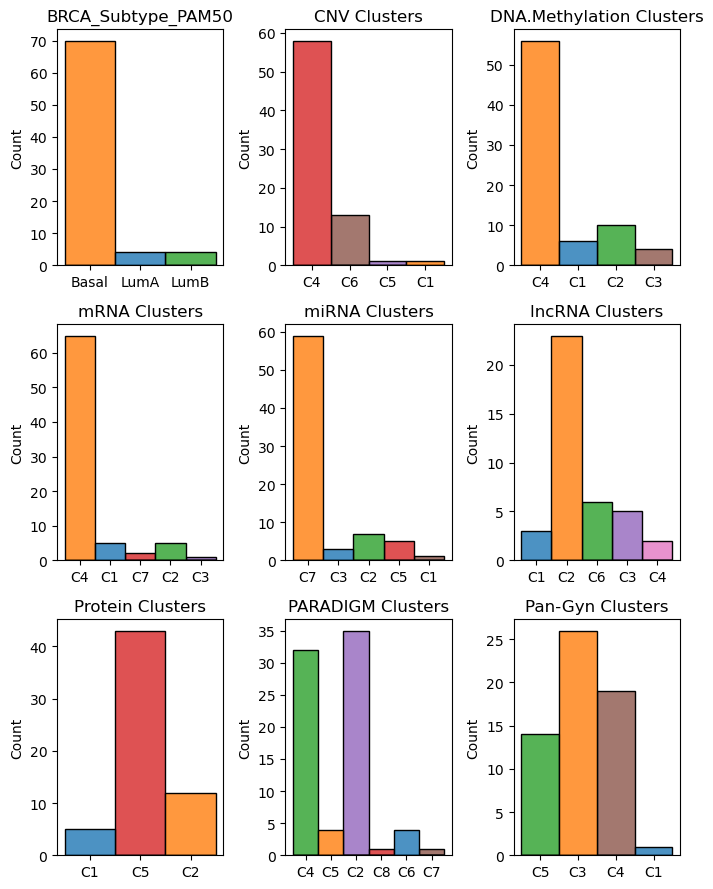

In [67]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(7, 9))

to_input = labels_df.loc[[to_heat.columns[i] for i in ensemble_cc[98]]].copy()

for i, c in enumerate(my_cols):

    sns.histplot(
        pd.DataFrame(to_input),
        x=c,
        hue=c,
        hue_order=labels_df.loc[to_heat.columns][c].unique(),
        legend=None,
        palette="tab10",
        alpha=0.8,
        ax=axs[i // 3, i % 3],
    )
    axs[i // 3, i % 3].set_title(c)
    axs[i // 3, i % 3].set_xlabel(None)


plt.tight_layout()
# plt.savefig("histplots_cluster.pdf")
plt.show()